<h1> Online Shoppers Intention Dataset </h1>

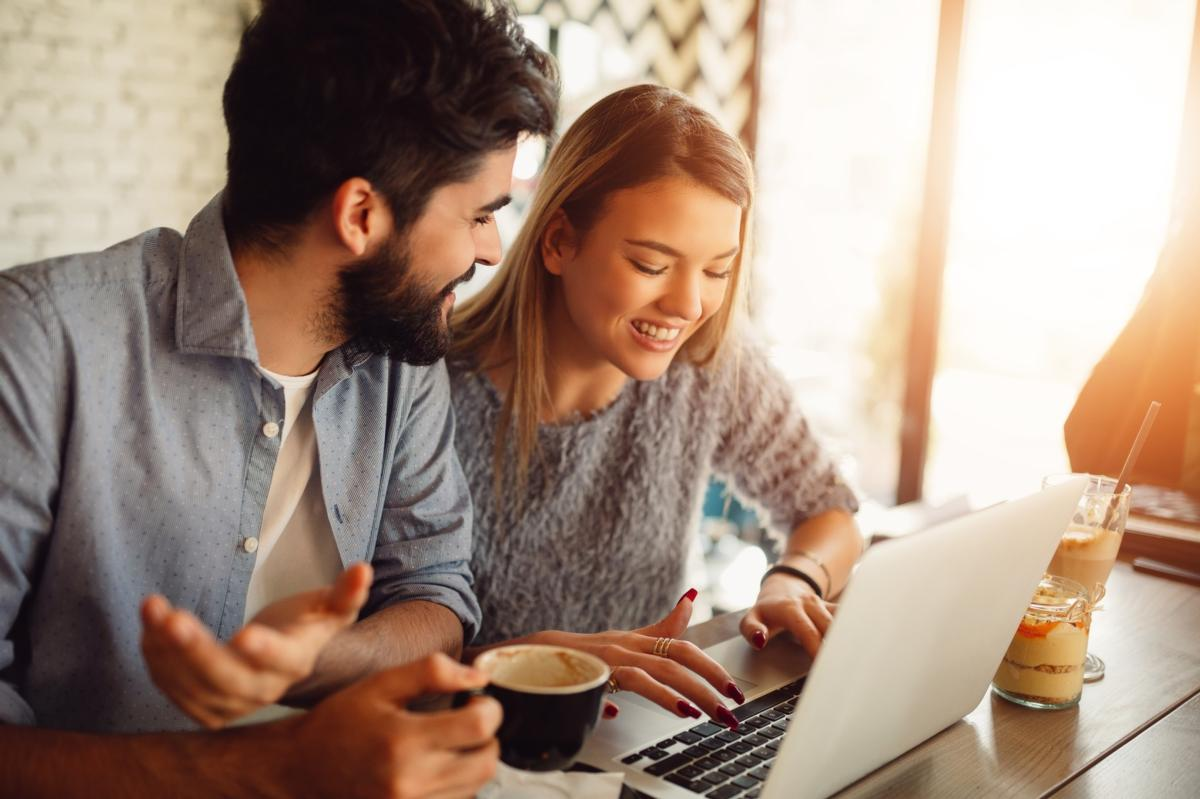

# Summary
---
 - [Import libs](#Libs)
 - [Functions](#Functions)
 - [The subject](#TheProblem)
 - [Read Data](#Import)
 - [Let's look at the Data!](#Explore)
 - [Transfrom Data](#Convert)
    * [Test Dependency ](#Dependency)
    * [Buiding New Features](#NewFeatures)
    
- [What variables are more important?](#ThielU)
- [Prepare Data to ML](#ML)
- [Modeling](#ML2)

<a id='Libs' a/>
<h1> Import Libs </h1>
<hr></hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##  Math & Statistics
import math
from collections import Counter
import scipy.stats as ss
from scipy.stats import chi2, \
                        chi2_contingency

#Metrics
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix

import warnings
warnings.filterwarnings("ignore")

<a id='Functions' a/>
<h1> Functions </h1>
<hr></hr>

In [2]:
# Function that execute the qui-square test
def test_dependency(alpha, cont):
    conf = 1-alpha
    X2, p, dof, expected = chi2_contingency(cont)
    critical = chi2.ppf(conf, dof)
    if abs(X2) >= critical:
        print('dependent (reject H0)')
    else:
        print('independent (fail to reject H0)')


def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

# Uncertainty coefficient or Thiel's U
def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

<a id='TheProblem' a/>

## **About Data**

Each data entry (row) is refer to one online session, that can be from the same user or not within a period of 1-year. Totalizing 12,330 sessions. 

The data has a set of variables like the type of page visited, amount of time spent, proximity to special dates, Browser used, and also Google Analytics Metrics like "Bounce Rate", "Exit Rate", and "Page Value". 

For each entry, the column "Revenue" is marked as 1 if that session generated revenue.  

## **Some questions our stakeholders may ask, in order to predict when a visitor is susceptible to buy, or what strategies they may use to improve the chance of sessions generate revenues**
What was the behavior of sessions resulting in purchases, and non-purchases?

How much time visitors spent at our sites in revenued sessions?

What kind of pages they access?

Are the weekends or special day's proximity relevant to they decision?



<a id='Import' a/>
<h1> Read data </h1>
<hr></hr>

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv


In [4]:
df = pd.read_csv("/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv")

<a id='Explore' a/>
<h1> Let's look at the Data! </h1>
<hr></hr>

In [5]:
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

### Dataset has no null values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [7]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [8]:
df.head(4)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False


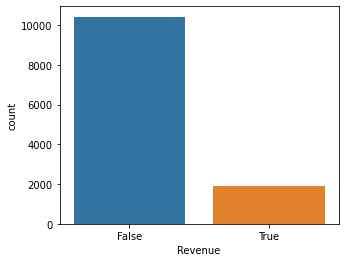

In [9]:
fig, axs = plt.subplots(figsize=(5,4))
g = sns.countplot(x='Revenue', data=df, ax=axs)

#### The Data is inbalanced, with roughly 85% (10422) of Non-Revenue vs 15% (1902) of Revenue sessions

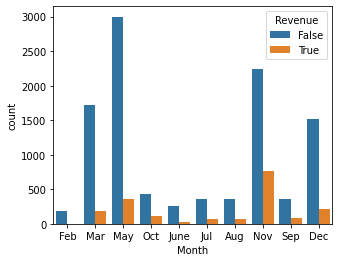

In [10]:
fig, axs = plt.subplots(figsize=(5,4))
g = sns.countplot(x='Month', data=df, ax=axs, hue='Revenue')

#### The Months with most online sessions are March, May, November and December. This may be caused by the important holiday, and special days in these months like: 
- **Woman's Day (Mar)**
- **Mother's day (May)**
- **Brack Friday, and Thanks Giving (Nov)**
- **Christmas , and Happy New Year (Dec)**

#### Although there is a discrepancy between Revenue and Non-Revenue visitors, the distributions are similar. Showing that most of purchases was made in these months

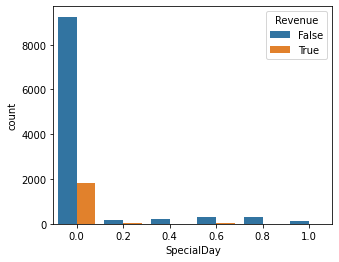

In [11]:
fig, axs = plt.subplots(figsize=(5,4))
g = sns.countplot(x='SpecialDay', data=df, ax=axs, hue='Revenue')

#### If we take a look at the "SpecialDay" column, we can see that most of the often revenued sessions were made 13 days after or 1 day after especial days, considering the dynamics of e-commerce such as the duration between the order date and delivery date.

In [12]:
df[['SpecialDay','Month','Revenue']].groupby('Month').sum()

,SpecialDay,Revenue
Month,,
Aug,0.0,76
Dec,0.0,216
Feb,43.0,3
Jul,0.0,66
June,0.0,29
Mar,0.0,192
May,714.4,365
Nov,0.0,760
Oct,0.0,115


#### The number of sessions close to special days was greater in May, and near of 51% of these sessions where revenued

In [13]:
pd.crosstab(df['Weekend'],df['Revenue'], margins=True)

Revenue,False,True,All
Weekend,,,
False,8053,1409,9462
True,2369,499,2868
All,10422,1908,12330


#### And about week days, weekend improves Revenues by about 2,5% (17.40 % more Revenues in weekends against 14.90 % on weekdays)

## Taking a look at Google Analytics metrics

In [14]:
df[['BounceRates','Revenue']].groupby('Revenue').mean()

,BounceRates
Revenue,
False,0.025317
True,0.005117


#### The bounce rate measure the percentage of visitors who enter the site then leave. If this page is only your home page, it's not good, this means that your visitors don't take any action and leave your page.
#### Bounce Rate is greater in non-revened sessions (25% to non-revenue against 5% to revenue). Sessions, when the amount of people visiting the site is greater than these leaving, is more likely to be revenue

In [15]:
df[['ExitRates','Revenue']].groupby('Revenue').mean()

,ExitRates
Revenue,
False,0.047378
True,0.019555


#### Exit Rate  refer to the percentage of visitors to a page on the website from which they exit the website to a different website.
#### For revenued sessions, near of 20% of the sessions has started and ended at the same page, for non-revenued 50%. In other words, engaged people, who see more than only one page in the your site, has more chance to generate revenue


In [16]:
df[['PageValues','Revenue']].groupby('Revenue').mean()

,PageValues
Revenue,
False,1.975998
True,27.264518


#### Page Value is the average value for a page that a user visited before landing on the goal page or completing an Ecommerce transaction. For revenued sessions, the average Page Value is 27.00 and for non-revenued is about 2.00

<a id='Convert' a/>
<h1> Prepare Data </h1>
<hr></hr>

<h4> In order to use Machine Learning Algorithms, we need to convert categorical-nominal to numerical data</h4>

In [17]:
from sklearn.model_selection import train_test_split
# Divide X and y
y = df['Revenue']
X = df.drop(['Revenue'], axis=1)

# Split dataset
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [18]:
y_train = y_train.map({True:1, False:0})
y_valid = y_valid.map({True:1, False:0})

# A class to preprocess dataset
### Convert categorical and boolean to numeric

In [19]:
import fuzzywuzzy
from fuzzywuzzy import process

class CustomPreProcessing():

    def __init__(self, min_ratio = 80, verbose = False):
        if(verbose):
            print("__init__")
        self.__class__.__name__ = 'CustomPreProcessing'
        self.min_ratio = min_ratio
        self.data = pd.DataFrame({'No data' : []})
        self.verbose = verbose

    
    def replace_matches_in_column(self, column, string_to_match, verbose=False):
        # get a list of unique strings
        strings = self.data[column].unique()
        
        # get the top 10 closest matches to our input string
        matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                            limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

        # only get matches with a ratio > 90
        close_matches = [matches[0] for matches in matches if matches[1] >= self.min_ratio]
        if (verbose):
            print(f'Searching for:{string_to_match}, close match: {close_matches}')
        # get the rows of all the close matches in our dataframe
        rows_with_matches = self.data[column].isin(close_matches)

        # replace all rows with close matches with the input matches 
        self.data.loc[rows_with_matches, column] = string_to_match

    def rem_inconsistent_date(self, X, values):
        if(self.verbose):
            print("rem_inconsistentdata")

        for val in values:
            self.replace_matches_in_column('Month', val)
    
    def map_months(self, months):
        if(self.verbose):    
            print('map_months')
        self.data['Month'] = self.data['Month'].map(dict((v,k+1) for k,v in enumerate(months)))
    
    def map_visitors(self, visitor_type):
        if(self.verbose):
            print('map_visitor_type')
        self.data['VisitorType'] = self.data['VisitorType'].map(dict((v,k) for k,v in enumerate(visitor_type)))
    
    def map_weekend(self):
        if(self.verbose):
            print('map_weekeend')     
        self.data['Weekend'] = self.data['Weekend'].map({True:1, False:0})
       

    def fit(self, X, y = None):
        if(self.verbose):
            print('fit')
        return self
    
    def transform(self, X, y = None):
        if(self.verbose):
            print("transform")

        self.data = X.copy()

        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Oct','Sep','Nov','Dec']
        visitor_type = ['Returning_Visitor', 'New_Visitor','Other']

        try:
            
            # remove inconsistentdata
            self.rem_inconsistent_date(self.data, months)

            # mapping months from str to numeric
            self.map_months(months)

            # mapping visitortype from str to numeric
            self.map_visitors(visitor_type)

            # mapping Weekend from boolean to numeric
            self.map_weekend()

        except KeyError as ke:
            print(ke)
            pass
        finally:
            return self.data



    def __repr__(self):
        return 'CustomPreProcessing'

    def getdata(self):
        return self.data

# Make a baseline model

In [20]:
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

scoring = ('roc_auc','accuracy','precision','recall')

baseline = Pipeline([
                ('Preprocessor',CustomPreProcessing(min_ratio=80, verbose=False)),
                ('model',XGBClassifier(eval_metric='logloss'))])
scores = cross_validate(baseline, X_train_full, y_train, cv=5, scoring=scoring)

In [21]:
for k, v in scores.items():
    print(k, np.round(v.mean(),4)) 

fit_time 0.7004
score_time 0.0519
test_roc_auc 0.9262
test_accuracy 0.9005
test_precision 0.7075
test_recall 0.5801


#### As we have categorical variables, we can verify the dependence between it. This can be made using the chi-square test

<a id='Dependency' a/>
<h2> Test dependency of Revenue and categorical variables </h2>

In [22]:
cat_var = ['SpecialDay','Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
for var in cat_var:
    cont = pd.crosstab(df['Revenue'], df[var])
    print("Revenue and "+var+" are:",end=" ")
    test_dependency(0.05, cont)

Revenue and SpecialDay are: dependent (reject H0)
Revenue and Month are: dependent (reject H0)
Revenue and OperatingSystems are: dependent (reject H0)
Revenue and Browser are: dependent (reject H0)
Revenue and Region are: independent (fail to reject H0)
Revenue and TrafficType are: dependent (reject H0)
Revenue and VisitorType are: dependent (reject H0)
Revenue and Weekend are: dependent (reject H0)


#### The chi-square test shows that Region and Revenue are independent. This variable may be unuseful to use in ML algorithms

<a id='NewFeatures' a/>
<h2> Building New Features </h2>

In [23]:
df['TotalPages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']

df['TotalTime'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']

df['Adm_time_per_page'] = (df['Administrative_Duration']/df['Administrative']).fillna(0)

df['Info_time_per_page'] = (df['Informational_Duration']/df['Informational']).fillna(0)

df['Pr_time_per_page'] = (df['ProductRelated_Duration']/df['ProductRelated']).fillna(0)

<a id='ThielU' a/>
<h1> What variables are most important to explain Revenued sessions?</h1>
<hr></hr>

Theil's U or Uncertainty Coefficient is a measure of nominal association. Sometimes expressed as U(x|y). Is the measure of entropy in variable y that variable x explains. Thiel's U is measured in the range of [0,1], where 0 means that feature y provides no information about feature x, and 1 means that feature y provides full information abpout features x's value.

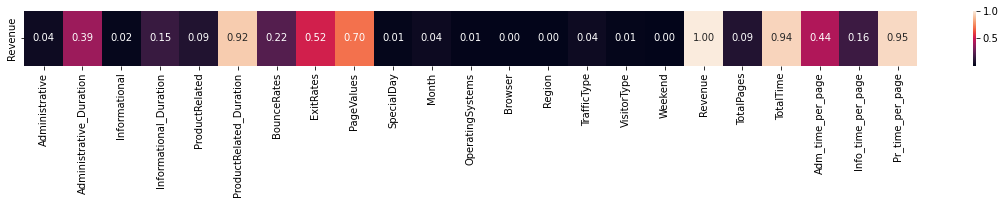

In [24]:
theilu = pd.DataFrame(index=['Revenue'],columns=df.columns)
columns = df.columns
for j in range(0,len(columns)):
    u = theil_u(df['Revenue'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

#### Seems like TotalTime, Adm_time_per_page, and Pr_time_per_page, was most significative to Revenue

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

model = Pipeline([ 
                ('Preprocessor', CustomPreProcessing(min_ratio=80, verbose=False)),
                ('Scaler', StandardScaler()),
                ('SMOTE()', SMOTE()),
                ('model', XGBClassifier(eval_metric='logloss'))])
                
scores = cross_validate(model, X_train_full, y_train, cv=5, scoring=scoring)

for k, v in scores.items():
    print(k, np.round(v.mean(),4)) 

fit_time 1.515
score_time 0.0548
test_roc_auc 0.9257
test_accuracy 0.8976
test_precision 0.6716
test_recall 0.6292


## References:

https://en.wikipedia.org/wiki/Uncertainty_coefficient,

https://www.statisticshowto.com/uncertainty-coefficient/

https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival